In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/raid/home/chandanj/miniconda3/envs/raghava/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ----------------------------
# 1. Diffusion Schedule
# ----------------------------
T = 1000
beta = torch.linspace(1e-4, 0.02, T)
alpha = 1 - beta
alpha_cumprod = torch.cumprod(alpha, dim=0)
sqrt_acp = torch.sqrt(alpha_cumprod)
sqrt_omacp = torch.sqrt(1 - alpha_cumprod)


In [3]:
# ----------------------------
# 2. U-Net (in_ch=2) predicting x0
# ----------------------------
class UNet2ch(nn.Module):
    def __init__(self, base_ch=64):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU(inplace=True),
            )
        # Encoder
        self.enc1 = conv_block(2, base_ch)
        self.enc2 = conv_block(base_ch, base_ch*2)
        self.enc3 = conv_block(base_ch*2, base_ch*4)
        self.pool = nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = conv_block(base_ch*4, base_ch*8)
        # Decoder
        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, 2, stride=2)
        self.dec3 = conv_block(base_ch*8, base_ch*4)
        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 2, stride=2)
        self.dec2 = conv_block(base_ch*4, base_ch*2)
        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 2, stride=2)
        self.dec1 = conv_block(base_ch*2, base_ch)
        # Final: predict x0 (1 channel)
        self.final = nn.Conv2d(base_ch, 1, 1)

    def forward(self, x):
        # x: [B,2,H,W] = (noisy image, t channel)
        e1 = self.enc1(x)              # [B, base, H, W]
        e2 = self.enc2(self.pool(e1))  # [B,2base, H/2, W/2]
        e3 = self.enc3(self.pool(e2))  # [B,4base, H/4, W/4]
        b  = self.bottleneck(self.pool(e3))  # [B,8base, H/8, W/8]
        d3 = self.dec3(torch.cat([self.up3(b),  e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)          # [B,1,H,W]

In [4]:
# ----------------------------
# 3. DDPM predicting x0, with 2-channel input
# ----------------------------
class DDPMx0_2ch(nn.Module):
    def __init__(self):
        super().__init__()
        self.unet = UNet2ch(base_ch=64)
        # register buffers so they move with .to(device)
        self.register_buffer('beta',          beta)
        self.register_buffer('alpha',         alpha)
        self.register_buffer('alpha_cumprod', alpha_cumprod)
        self.register_buffer('sqrt_acp',      sqrt_acp)
        self.register_buffer('sqrt_omacp',    sqrt_omacp)

    def q_sample(self, x0, t, noise):
        # x_t = √(ᾱ_t)·x0 + √(1−ᾱ_t)·noise
        return ( self.sqrt_acp[t].view(-1,1,1,1)*x0
               + self.sqrt_omacp[t].view(-1,1,1,1)*noise )

    def forward(self, x0, t):
        """
        Training: predict x0 from x_t
        Loss = MSE(x0_hat, x0)
        """
        noise = torch.randn_like(x0)
        x_t   = self.q_sample(x0, t, noise)         # add noise
        # build a single‐channel time map
        B,_,H,W = x0.shape
        t_chan  = t.view(-1,1,1,1).expand(-1,1,H,W)  # [B,1,H,W]
        inp     = torch.cat([x_t, t_chan], dim=1)    # [B,2,H,W]
        x0_hat  = self.unet(inp)                     # predict x0
        return F.mse_loss(x0_hat, x0)                # train to match true x0

In [5]:
# ----------------------------
# 4. Sampling / Inference
# ----------------------------
@torch.no_grad()
def sample(model, shape, device):
    x = torch.randn(shape, device=device)         # start from noise [B,1,H,W]
    B,_,H,W = shape

    # iterate backwards
    for i in reversed(range(1, T)):
        t = torch.full((B,), i, device=device, dtype=torch.long)
        # predict x0
        t_chan = t.view(-1,1,1,1).expand(-1,1,H,W) # [B,1,H,W]
        inp    = torch.cat([x, t_chan], dim=1)     # [B,2,H,W]
        x0_hat = model.unet(inp)

        # sample x_{t-1} ~ N(√(ᾱ_{t-1}) x0_hat, 1-ᾱ_{t-1})
        acp_prev = model.alpha_cumprod[i-1]
        mean     = math.sqrt(acp_prev) * x0_hat
        if i > 1:
            noise = torch.randn_like(x)
            sigma = math.sqrt(1 - acp_prev)
            x = mean + sigma * noise
        else:
            x = mean

    return x.clamp(0,1)  # final image


Epoch 1/15  Loss: 0.1061
Epoch 2/15  Loss: 0.0664
Epoch 3/15  Loss: 0.0618
Epoch 4/15  Loss: 0.0512
Epoch 5/15  Loss: 0.0428
Epoch 6/15  Loss: 0.0416
Epoch 7/15  Loss: 0.0413
Epoch 8/15  Loss: 0.0406
Epoch 9/15  Loss: 0.0401
Epoch 10/15  Loss: 0.0395
Epoch 11/15  Loss: 0.0391
Epoch 12/15  Loss: 0.0389
Epoch 13/15  Loss: 0.0386
Epoch 14/15  Loss: 0.0382
Epoch 15/15  Loss: 0.0382


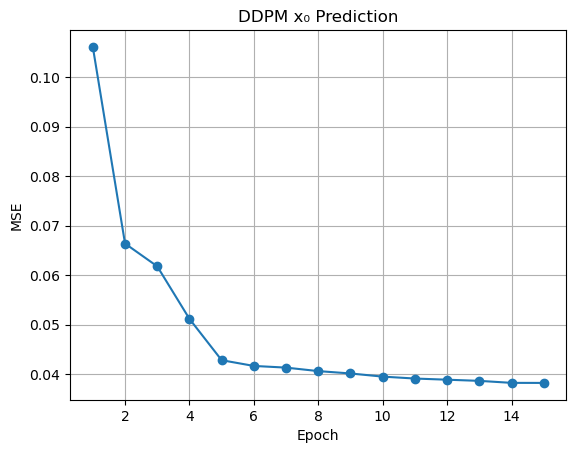

In [9]:
# ----------------------------
# 5. Train on MNIST
# ----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True,
        transform=transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor()
        ])
    ),
    batch_size=128, shuffle=True, num_workers=2
)

model = DDPMx0_2ch().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 15
losses = []

for ep in range(1, epochs+1):
    model.train()
    total = 0.0
    for x,_ in loader:
        x = x.to(device)                         # [B,1,32,32]
        t = torch.randint(0, T, (x.size(0),), device=device)
        loss = model(x, t)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()
    avg = total / len(loader)
    print(f'Epoch {ep}/{epochs}  Loss: {avg:.4f}')
    losses.append(avg)

# plot training loss
plt.plot(range(1, epochs+1), losses, marker='o')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('DDPM x₀ Prediction'); plt.grid(True)
plt.show()

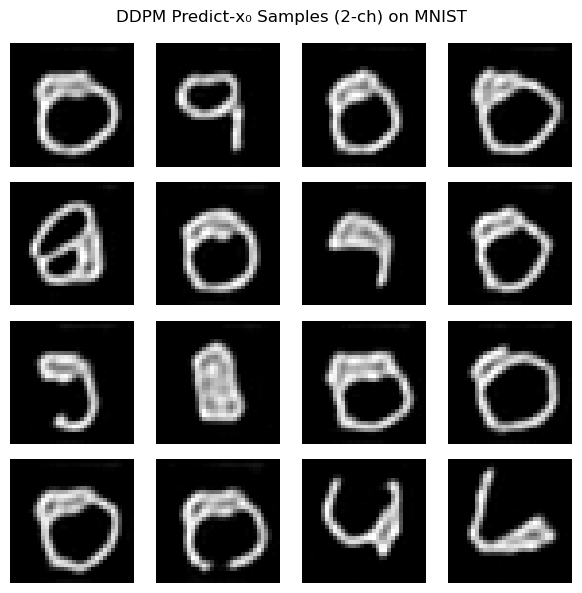

In [10]:
# ----------------------------
# 6. Generate & display samples
# ----------------------------
model.eval()
samples = sample(model, (16,1,32,32), device).cpu()
fig, axs = plt.subplots(4,4, figsize=(6,6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(samples[i,0], cmap='gray')
    ax.axis('off')
plt.suptitle('DDPM Predict-x₀ Samples (2-ch) on MNIST')
plt.tight_layout()
plt.show()